In [72]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from collections import Counter

### class_probability(train) function implemented below calculates the probability of each class based on the number of the documents present in that class

In [71]:
def class_probability(train):
    Pc = {}
    docs_count = train.groupby('category')['TEXT'].count()
    total = len(train)
    total_cls = len(docs_count)
    for i in range(total_cls):
        Pc[i] = docs_count[i]/total
    return Pc, total_cls

### Using the below function, as the name suggest, we will train our model and calculate the following probability distribution of the words in each class which will further be used for testing purposes.

Both the classification and the sumarization will be carried out using naive Bayes. This is an inductive statistical method based on the Bayes Theorem, expressed as a relationship between a priori and a posteriori probability of a assumptions. Thus, for the classification we have: <br>

• P(C = ck) is the a priori probability of CK class <br>

• P(C = ck|x) is the posteriori probability of CK class after x it is observed <br>

• P(x|C = ck) is the probability that x will be in CK class (verosimability, engg. likelihood) <br>

• P(x) is the probability of observations (eng. evidence)

In [89]:
def training(train,Pc,total_cls,datatype='PRE_TEXT',alpha=1):
    words = {}
    Vocab = []
    word_to_idx = {}
    word_count = {}

    for i in range(total_cls):
        words[i] = []

    for index, row in train.iterrows():
        raw_text = row[datatype]
        tokens = raw_text.split(' ')
        words[row['category']] += tokens
        Vocab += tokens
    Vocab = list(set(Vocab))
    Vocab.append(-1) # For words which dont exist in Vocab 

    for i in range(len(Vocab)):
        word_to_idx[Vocab[i]] = i
    
    for i in range(total_cls):
        word_count[i] = Counter(words[i])
    
    V = len(Vocab)
    Pxi_c = {}
    for i in range(total_cls):
        Pxi_c[i] = [0]*V
        total_count = len(word_count[i]) # total words in class i
        for word in Vocab:
            idx = word_to_idx[word]
            if word in word_count[i]:
                value = word_count[i][word]
            else:
                value = 0
            prob = (value + alpha)/(total_count + V + alpha) # Laplace smoothing
            Pxi_c[i][idx] = np.log(prob)

    return Pxi_c, Vocab, word_to_idx

### Also as the name suggests we will make prediction using the below function

Flow will be as follows: <br>

From the test dataset, we will take 1 news article at a time and find the probability of  P(text|C = ck) is the probability that text will be in CK class
using the probability distribution created in the training dataset. This way we can predict which class the text belongs to using the predict()

In [93]:
def predict(test,Pxi_c,Vocab,Pc,datatype,id_to_type,word_to_idx,total_cls):
    y_test = []
    y_predict = []

    for index, row in test.iterrows():
        raw_text_test = row[datatype]
        y_test.append(row['SENTIMENT'])
        tokens_test = raw_text_test.split(' ')
        Vocab_test = []
        for i in range(len(tokens_test)):
            word = tokens_test[i]
            if word not in Vocab:
                Vocab_test.append(-1)
            else:
                Vocab_test.append(word)

        Pc_x = []
        for i in range(total_cls):
            Pxi_c_test = []
            for word in Vocab_test:
                idx = word_to_idx[word]
                Pxi_c_test.append(Pxi_c[i][idx])
            Px_c_test = sum(Pxi_c_test)
            prob = np.log(Pc[i]) + Px_c_test
            Pc_x.append(prob)
        predict = np.argmax(np.array(Pc_x))
        y_predict.append(id_to_type[predict])
    return y_test, y_predict

In [100]:
def accuracy_model(y_true, y_pred):
    count = 0
    for i in range(len(y_true)):
        if y_true[i]==y_pred[i]:
            count += 1
    return count/len(y_true)

In [ ]:
df1 = pd.read_csv('train.csv', sep=';')
df1['category'] = df1['SENTIMENT'].factorize()[0]

In [ ]:
df2 = pd.read_csv('test.csv', sep=';')
df2['category'] = df2['SENTIMENT'].factorize()[0]

In [ ]:
df1.sample(5, random_state=20)

,SENTIMENT,TEXT,category
613,Positive,"What I want, I buy here",0
3815,Neutral,"Range of goods,",2
8148,Positive,"I come here all the time, I like it here, I'm ...",0
5193,Negative,"Heaven is as big a choice as it is down here, ...",1
9123,Negative,Uncomfortable operation.,1


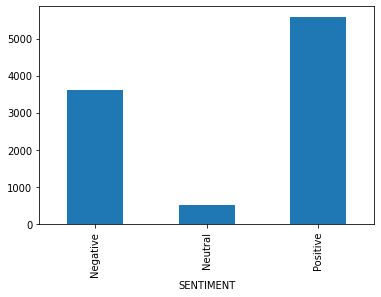

In [ ]:
df1.groupby('SENTIMENT')['TEXT'].count().plot.bar(ylim=0) 

In [74]:
training = [row["TEXT"].lower()
          .replace(",", "").replace(".", "").replace("!", "").replace("?", "")
          .replace(";", "").replace(":", "").replace("*", "")
          .replace("(", "").replace(")", "")
          .replace("/", "")
          for index, row in df1.iterrows()]

testing = [row["TEXT"].lower()
          .replace(",", "").replace(".", "").replace("!", "").replace("?", "")
          .replace(";", "").replace(":", "").replace("*", "")
          .replace("(", "").replace(")", "")
          .replace("/", "")
          for index, row in df2.iterrows()]

In [76]:
df1['PRE_TEXT'] = training
df2['PRE_TEXT'] = testing

In [92]:
id_to_type = {0: 'Positive', 1: 'Negative', 2: 'Neutral'}

In [102]:
Pc, total_cls = class_probability(df1)

In [128]:
Pxi_c, Vocab, word_to_idx = training(df1, Pc, total_cls, alpha = 1e-8)

In [129]:
datatype = 'PRE_TEXT'
y_test, y_predict = predict(df2,Pxi_c,Vocab,Pc,datatype,id_to_type,word_to_idx,total_cls)

In [134]:
acc = accuracy_model(y_test, y_predict)
print('Accuracy (in %):',round(acc*100,3))

Accuracy (in %): 83.428
